# Markerville Backend

## Imports and Candidate Subclass

All the imports and the creation of the candidate_subclass or desired relationship to extract

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
from six.moves.cPickle import load
import cPickle
import numpy as np

from snorkel import SnorkelSession
from snorkel.parser import XMLMultiDocPreprocessor, CorpusParser
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser.corenlp import StanfordCoreNLPServer
from snorkel.models import Document, Sentence, Candidate, candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import LabelAnnotator, load_gold_labels, FeatureAnnotator, save_marginals, load_marginals
from snorkel.learning import SparseLogisticRegression, GenerativeModel, RandomSearch
from snorkel.learning.structure import DependencySelector
from snorkel.learning.utils import MentionScorer
# from snorkel.contrib.rnn import reRNN

import matchers
import LF
from candidate_adjective_fixer import *
from load_external_annotations_new import load_external_labels

session = SnorkelSession()

BiomarkerCondition = candidate_subclass('BiomarkerCondition', ['biomarker', 'condition'])



/Users/gmachiraju/py2_kernel/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 162 of the file /usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


The following can be ignored

In [2]:
#------------------
# Helper Functions
#------------------

def grabCandidates(extractor, schema):
    # Candidate Counts
    for k, sents in enumerate([train_sents, dev_sents, test_sents]):
        extractor.apply(sents, split=k, clear=False)
        print "Number of candidates: ", session.query(schema).filter(schema.split == k).count()
        session.commit()
        
    train_cands = session.query(schema).filter(
        schema.split == 0).all()
    dev_cands = session.query(schema).filter(
        schema.split == 1).all()
    test_cands = session.query(schema).filter(
        schema.split == 2).all()

    return [train_cands, dev_cands, test_cands]

## Setup and Preprocessing

Load in the XML files containing the corpuses. In this case, there are three, a training corpus, test corpus, and development corpus. 

In [3]:
#-----------------------
# Setup & Preprocessing
#-----------------------

# Instantiate the Session
session = SnorkelSession()

# Doc Preprocessing
file_path = 'articles/training.xml'
train_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//article',
    text='.//front/article-meta/abstract/p/text()',
    id='.//front/article-meta/article-id/text()'
)

file_path = 'articles/development.xml'
dev_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()'
)

file_path = 'articles/testcorpus.xml'
test_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()'
)

# Parsing
# corenlp_server = StanfordCoreNLPServer(version="3.6.0", num_threads=4, port=12348)
# corpus_parser = CorpusParser(corenlp_server, parser=Spacy())



Clearing existing...
Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%



The CorpusParser is applied to each of these corpuses to break them into Documents and Sentences

In [ ]:
corpus_parser = CorpusParser(parser=Spacy())
# corpus_parser = CorpusParser()

# Note: Parallelism can be run with a Postgres DBMS, but not SQLite
corpus_parser.apply(list(train_preprocessor))
corpus_parser.apply(list(dev_preprocessor), clear=False)
corpus_parser.apply(list(test_preprocessor), clear=False)



The sentences are then split into train, dev, and test according to the document IDs associated with them. 

In [4]:
# Retrieving Stable IDs for each of the candidate sentences
with open('articles/doc_ids.pkl', 'rb') as f:
    train_ids, dev_ids, test_ids = load(f)

train_ids, dev_ids, test_ids = set(train_ids), set(dev_ids), set(test_ids)
train_sents, dev_sents, test_sents = set(), set(), set()
docs = session.query(Document).order_by(Document.name).all()


# Assigning each sentence to {train,dev,test}-set based on Stable ID
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name in train_ids:
            train_sents.add(s)
        elif doc.name in dev_ids:
            dev_sents.add(s)
        elif doc.name in test_ids:
            test_sents.add(s)
        else:
            raise Exception(
                'ID <{0}> not found in any id set'.format(doc.name))

## Candidate Extraction

The Ngrams for each entity, or number of words to match, is established. Then the matchers (collection of regular expressions and dictionaries) are initialized. 

The matchers, ngrams, and candidate_subclass are passed into the CandidateExtractor to extract candidates. 

In [5]:
#----------------------
# Candidate Extraction
#----------------------

# Defining the Candidate Schemas
# BiomarkerCondition = candidate_subclass('BiomarkerCondition', ['biomarker', 'condition'])

# BiomarkerDrug = candidate_subclass('BiomarkerDrug', ['biomarker', 'drug'])
# BiomarkerMedium = candidate_subclass('BiomarkerMedium', ['biomarker', 'medium'])
# BiomarkerType = candidate_subclass('BiomarkerType', ['biomarker', 'typ3'])
# # BiomarkerLevelUnit = candidate_subclass('BiomarkerLevelUnit', ['biomarker', 'level', 'unit'])
#can eventually add MEASUREMENT and COHORT SIZE among other entities

# N-grams: the probabilistic search space of our entities
biomarker_ngrams = Ngrams(n_max=1)
condition_ngrams = Ngrams(n_max=7)
# drug_ngrams = Ngrams(n_max=5)
# medium_ngrams = Ngrams(n_max=5)
# type_ngrams = Ngrams(n_max=5)  # <--- Q: should we cut these down?
# # level_ngrams = Ngrams(n_max=1)
# unit_ngrams = Ngrams(n_max=1)

# Construct our Matchers
bMatcher = matchers.getBiomarkerMatcher()
cMatcher = matchers.getConditionMatcher()
# dMatcher = matchers.getDrugMatcher()
# mMatcher = matchers.getMediumMatcher()
# tMatcher = matchers.getTypeMatcher()
# lMatcher = matchers.getLevelMatcher()
# uMatcher = matchers.getUnitMatcher()

# Building the CandidateExtractors
candidate_extractor_BC = CandidateExtractor(BiomarkerCondition, [biomarker_ngrams, condition_ngrams], [bMatcher, cMatcher])
# candidate_extractor_BD = CandidateExtractor(BiomarkerDrug, [biomarker_ngrams, drug_ngrams], [bMatcher, dMatcher])
# candidate_extractor_BM = CandidateExtractor(BiomarkerMedium, [biomarker_ngrams, medium_ngrams], [bMatcher, mMatcher])
# candidate_extractor_BT = CandidateExtractor(BiomarkerType, [biomarker_ngrams, type_ngrams], [bMatcher, tMatcher])
# candidate_extractor_BLU = CandidateExtractor(BiomarkerLevelUnit, [biomarker_ngrams, level_ngrams, unit_ngrams], [bMatcher, lMatcher, uMatcher])

# List of Candidate Sets for each relation type: [train, dev, test]
cands_BC = grabCandidates(candidate_extractor_BC, BiomarkerCondition)
# cands_BD = grabCandidates(candidate_extractor_BD, BiomarkerDrug)
# cands_BM = grabCandidates(candidate_extractor_BM, BiomarkerMedium)
# cands_BT = grabCandidates(candidate_extractor_BT, BiomarkerType)
# cands_BLU = grabCandidates(candidate_extractor_BLU, BiomarkerLevelUnit)



ASDFASDF
Running UDF...
[========================================] 100%

Number of candidates:  2347
Running UDF...
[========================================] 100%

Number of candidates:  622
Running UDF...
[========================================] 100%

Number of candidates:  119


In case of specificity issues, for medium, condition, and drug, grabs the adjectives in front of the entity as well. The goal is to have more specific entities, such as esophaegal cancer rather than just cancer. 

In [6]:
session.rollback()
print "Number of dev BC candidates without adj. boosting: ", len(cands_BC[1])
add_adj_candidate_BC(session, BiomarkerCondition, cands_BC[1], 0)
# fix_specificity(session, BiomarkerCondition, cands_BC[1])
print "Number of dev BC candidates with adj. boosting: ", session.query(BiomarkerCondition).filter(BiomarkerCondition.split == 1).count()
session.commit()

Number of dev BC candidates without adj. boosting:  622
Checking Biomarker: 28261684::span:168:174
Checking Condition: 28261684::span:24:36
0
Couldn't find: 28261684::span:24:36
ADDING NEW CANDIDATE
Checking Biomarker: 28261684::span:168:174
Checking Condition: 28261684::span:54:67
0
Couldn't find: 28261684::span:54:67
ADDING NEW CANDIDATE
Checking Biomarker: 28261345::span:505:508
Checking Condition: 28261345::span:175:197
0
Couldn't find: 28261345::span:175:197
ADDING NEW CANDIDATE
Checking Biomarker: 28261345::span:550:553
Checking Condition: 28261345::span:175:197
1
Checking Biomarker: 28261345::span:679:681
Checking Condition: 28261345::span:175:197
1
Checking Biomarker: 28261345::span:689:692
Checking Condition: 28261345::span:175:197
1
Checking Biomarker: 28261345::span:791:794
Checking Condition: 28261345::span:28:50
0
Couldn't find: 28261345::span:28:50
ADDING NEW CANDIDATE
Checking Biomarker: 28263001::span:707:708
Checking Condition: 28263001::span:66:80
0
Couldn't find: 282

Checking Biomarker: 28263922::span:514:516
Checking Condition: 28263922::span:148:159
0
Couldn't find: 28263922::span:148:159
ADDING NEW CANDIDATE
Checking Biomarker: 28260933::span:1557:1559
Checking Condition: 28260933::span:85:117
0
Couldn't find: 28260933::span:85:117
ADDING NEW CANDIDATE
Checking Biomarker: 28260933::span:1476:1485
Checking Condition: 28260933::span:85:117
1
Checking Biomarker: 28260933::span:1488:1490
Checking Condition: 28260933::span:85:117
1
Checking Biomarker: 28261345::span:1359:1363
Checking Condition: 28261345::span:46:68
0
Couldn't find: 28261345::span:46:68
ADDING NEW CANDIDATE
Checking Biomarker: 28261345::span:1222:1223
Checking Condition: 28261345::span:46:68
1
Checking Biomarker: 28261345::span:1127:1130
Checking Condition: 28261345::span:46:68
1
Checking Biomarker: 28261345::span:1159:1163
Checking Condition: 28261345::span:46:68
1
Checking Biomarker: 28261345::span:1082:1084
Checking Condition: 28261345::span:46:68
1
Checking Biomarker: 28261345::s

Checking Condition: 28261336::span:67:80
0
Couldn't find: 28261336::span:67:80
ADDING NEW CANDIDATE
Checking Biomarker: 28262197::span:1697:1706
Checking Condition: 28262197::span:16:34
0
Couldn't find: 28262197::span:16:34
ADDING NEW CANDIDATE
Checking Biomarker: 28261746::span:558:562
Checking Condition: 28261746::span:59:91
0
Couldn't find: 28261746::span:59:91
ADDING NEW CANDIDATE
Checking Biomarker: 28261746::span:320:322
Checking Condition: 28261746::span:59:91
1
Checking Biomarker: 28261746::span:324:330
Checking Condition: 28261746::span:59:91
1
Checking Biomarker: 28261746::span:550:555
Checking Condition: 28261746::span:59:91
1
Checking Biomarker: 28261746::span:569:571
Checking Condition: 28261746::span:59:91
1
Checking Biomarker: 28261746::span:310:318
Checking Condition: 28261746::span:59:91
1
Checking Biomarker: 28264096::span:1613:1615
Checking Condition: 28264096::span:255:266
0
Couldn't find: 28264096::span:255:266
ADDING NEW CANDIDATE
Checking Biomarker: 28264096::spa

## Labelling Functions

The weak supervision portion of the pipeline, these labelling funtions are used to label the training data. In order to modify the accuracy of the pipeline, these should be modified, and new labelling functions should be added. More information about evaluating the accuracy of labelling functions can be found on the Snorkel website

In [7]:
from LF import *
LFs_BC = [LF_markerDatabase, LF_keyword, LF_distance, LF_abstract_titleWord, LF_single_letter,
          LF_auxpass, LF_known_abs, LF_same_thing, LF_common_1000, LF_common_2000]

In [8]:
from snorkel.annotations import LabelAnnotator
BC_labeler = LabelAnnotator(lfs=LFs_BC)

## Train the final model

In [9]:
np.random.seed(1701)
%time L_train_BC = BC_labeler.apply(split=0)
L_train_BC

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 27s, sys: 271 ms, total: 1min 27s
Wall time: 1min 27s


<2438x10 sparse matrix of type '<type 'numpy.int64'>'
	with 7443 stored elements in Compressed Sparse Row format>

In [10]:
%time L_train_BC = BC_labeler.load_matrix(session, split=0)
L_train_BC

CPU times: user 59.4 ms, sys: 999 µs, total: 60.4 ms
Wall time: 59.7 ms


<2438x10 sparse matrix of type '<type 'numpy.int64'>'
	with 7443 stored elements in Compressed Sparse Row format>

In [11]:
L_train_BC.get_candidate(session, 0)

BiomarkerCondition(Span("PIT", sentence=11483, chars=[0,2], words=[0,0]), Span("thymoma", sentence=11483, chars=[138,144], words=[23,23]))

In [12]:
L_train_BC.get_key(session, 0)

LabelKey (LF_markerDatabase)

In [13]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train_BC, epochs=100, decay=0.95, step_size=0.1 / L_train_BC.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [14]:
gen_model.weights.lf_accuracy

array([-0.16343081, -0.04676583,  0.44594254,  0.08838548,  0.09636296,
        0.92470244,  0.09789258,  0.07900782,  0.20371016,  0.36489085])

In [15]:
train_marginals = gen_model.marginals(L_train_BC)


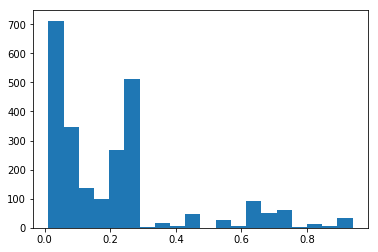

In [16]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [17]:
L_dev = BC_labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [18]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train_BC, train_marginals)

Saved 2438 marginals
CPU times: user 1.36 s, sys: 6.5 ms, total: 1.37 s
Wall time: 1.37 s


In [19]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

In [20]:
train_cands = session.query(BiomarkerCondition).filter(BiomarkerCondition.split == 0).order_by(BiomarkerCondition.id).all()
dev_cands   = session.query(BiomarkerCondition).filter(BiomarkerCondition.split == 1).order_by(BiomarkerCondition.id).all()
test_cands  = session.query(BiomarkerCondition).filter(BiomarkerCondition.split == 2).order_by(BiomarkerCondition.id).all()

In [21]:
from snorkel.annotations import load_gold_labels
load_external_labels(session, BiomarkerCondition, 'Biomarker', 'Condition', 'articles/disease_gold_labels.tsv', dev_cands, annotator_name='gold')
load_external_labels(session, BiomarkerCondition, 'Biomarker', 'Condition', 'articles/disease_gold_labels.tsv', test_cands, annotator_name='gold')

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=1)




AnnotatorLabels created: 622
AnnotatorLabels created: 119
AnnotatorLabels created: 0
AnnotatorLabels created: 0


In [22]:
print len(train_cands)
print len(dev_cands)

2438
622


In [23]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        50,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1002 has argument past max length for model:	[arg ends at index 114; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1004 has argument past max length for model:	[arg ends at index 114; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1520 has argument past max length for model:	[arg ends at index 100; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 1527 has argument 

[reRNN] Training model
[reRNN] n_train=2438  #epochs=10  batch size=256
[reRNN] Epoch 0 (2.97s)	Average loss=0.556301	Dev F1=0.00
[reRNN] Epoch 1 (6.14s)	Average loss=0.513642	Dev F1=0.00
[reRNN] Epoch 2 (9.32s)	Average loss=0.497819	Dev F1=4.60
[reRNN] Epoch 3 (12.47s)	Average loss=0.469032	Dev F1=5.41
[reRNN] Epoch 4 (15.55s)	Average loss=0.453651	Dev F1=19.86
[reRNN] Epoch 5 (18.68s)	Average loss=0.445668	Dev F1=29.11
[reRNN] Epoch 6 (21.82s)	Average loss=0.439488	Dev F1=28.25
[reRNN] Epoch 7 (25.24s)	Average loss=0.437417	Dev F1=29.63
[reRNN] Epoch 8 (28.64s)	Average loss=0.434741	Dev F1=30.77
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (33.11s)	Average loss=0.431667	Dev F1=31.69
[reRNN] Model saved as <reRNN>
[reRNN] Training done (34.83s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-9
[reRNN] Loaded model <reRNN>


The below information is generated using the test set as an accuracy metric

In [25]:
p, r, f1 = lstm.score(dev_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 309 has argument past max length for model:	[arg ends at index 106; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 494 has argument past max length for model:	[arg ends at index 101; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 495 has argument past max length for model:	[arg ends at index 101; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/Users/gmachiraju/Documents/markerville-backend/markerville-backend/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 496 has argument past

Prec: 0.242, Recall: 0.460, F1 Score: 0.317


In [27]:
tp, fp, tn, fn = lstm.error_analysis(session, dev_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.46
Neg. class accuracy: 0.837
Precision            0.242
Recall               0.46
F1                   0.317
----------------------------------------
TP: 29 | FP: 91 | TN: 468 | FN: 34



In [28]:
lstm.save_marginals(session, test_cands)

Saved 119 marginals


In [29]:
predictions = lstm.predictions(train_cands)

In [30]:
i = 0
for prediction in predictions: 
    if(prediction == 1):
        i+=1
print i

253


In [31]:
i = 0
while( i< len(train_cands)):
    print("Candidate: {}. Prediction: {}").format(train_cands[i], predictions[i])
    i += 1

Candidate: BiomarkerCondition(Span("PIT", sentence=11483, chars=[0,2], words=[0,0]), Span("thymoma", sentence=11483, chars=[138,144], words=[23,23])). Prediction: 1
Candidate: BiomarkerCondition(Span("DLB", sentence=2206, chars=[180,182], words=[29,29]), Span("epilepsy", sentence=2206, chars=[91,98], words=[12,12])). Prediction: -1
Candidate: BiomarkerCondition(Span("DLB", sentence=2206, chars=[180,182], words=[29,29]), Span("dementia", sentence=2206, chars=[111,118], words=[14,14])). Prediction: -1
Candidate: BiomarkerCondition(Span("DLB", sentence=2206, chars=[180,182], words=[29,29]), Span("dementia", sentence=2206, chars=[153,160], words=[24,24])). Prediction: -1
Candidate: BiomarkerCondition(Span("DLB", sentence=2206, chars=[180,182], words=[29,29]), Span("vascular dementia", sentence=2206, chars=[125,141], words=[18,19])). Prediction: -1
Candidate: BiomarkerCondition(Span("III", sentence=3694, chars=[17,19], words=[3,3]), Span("breast cancer", sentence=3694, chars=[138,150], word

Candidate: BiomarkerCondition(Span("SNP", sentence=11127, chars=[231,233], words=[38,38]), Span("cancer", sentence=11127, chars=[155,160], words=[24,24])). Prediction: -1
Candidate: BiomarkerCondition(Span("SNP", sentence=11127, chars=[231,233], words=[38,38]), Span("cancer", sentence=11127, chars=[328,333], words=[56,56])). Prediction: -1
Candidate: BiomarkerCondition(Span("CI", sentence=12886, chars=[106,107], words=[21,21]), Span("breast cancer", sentence=12886, chars=[171,183], words=[37,38])). Prediction: -1
Candidate: BiomarkerCondition(Span("CI", sentence=12886, chars=[135,136], words=[29,29]), Span("breast cancer", sentence=12886, chars=[171,183], words=[37,38])). Prediction: -1
Candidate: BiomarkerCondition(Span("CIPN", sentence=9306, chars=[44,47], words=[6,6]), Span("neuropathy", sentence=9306, chars=[32,41], words=[4,4])). Prediction: -1
Candidate: BiomarkerCondition(Span("CIPN", sentence=9306, chars=[44,47], words=[6,6]), Span("cancer", sentence=9306, chars=[118,123], word

Candidate: BiomarkerCondition(Span("CI", sentence=8213, chars=[150,151], words=[33,33]), Span("cancer", sentence=8213, chars=[73,78], words=[13,13])). Prediction: -1
Candidate: BiomarkerCondition(Span("KEGG", sentence=12289, chars=[38,41], words=[7,7]), Span("melanoma", sentence=12289, chars=[121,128], words=[24,24])). Prediction: -1
Candidate: BiomarkerCondition(Span("PANTHER", sentence=12289, chars=[44,50], words=[9,9]), Span("melanoma", sentence=12289, chars=[121,128], words=[24,24])). Prediction: -1
Candidate: BiomarkerCondition(Span("DAVID", sentence=12289, chars=[31,35], words=[5,5]), Span("melanoma", sentence=12289, chars=[121,128], words=[24,24])). Prediction: -1
Candidate: BiomarkerCondition(Span("WM-266", sentence=12289, chars=[112,117], words=[21,21]), Span("melanoma", sentence=12289, chars=[121,128], words=[24,24])). Prediction: -1
Candidate: BiomarkerCondition(Span("GAD", sentence=12289, chars=[82,84], words=[17,17]), Span("melanoma", sentence=12289, chars=[121,128], words

Export the Final Model

In [32]:
lstm.save('biomarker')

[reRNN] Model saved as <biomarker>
